In [ ]:
# Copyright 2023 Nils Knieling
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini

[![Open in Colab](https://img.shields.io/badge/Open%20in%20Colab-%23F9AB00.svg?logo=googlecolab&logoColor=white)](https://colab.research.google.com/github/Cyclenerd/toolbox/blob/master/notebooks/Gemini.ipynb)
[![Open in Vertex AI Workbench](https://img.shields.io/badge/Open%20in%20Vertex%20AI%20Workbench-%234285F4.svg?logo=googlecloud&logoColor=white)](https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/Cyclenerd/toolbox/master/notebooks/Gemini.ipynb)
[![View on GitHub](https://img.shields.io/badge/View%20on%20GitHub-181717.svg?logo=github&logoColor=white)](https://github.com/Cyclenerd/toolbox/blob/master/notebooks/Gemini.ipynb)

My attempt to solve the puzzle mentioned in the developer [blog](https://developers.googleblog.com/2023/12/how-its-made-gemini-multimodal-prompting.html).

This is a secret message. What does it say?

![Image: Hands](https://raw.githubusercontent.com/Cyclenerd/toolbox/master/notebooks/gemini/secret_message.png)

Docs: <https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/send-multimodal-prompts>

API: <https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/gemini>


## Install required packages

>⚠️ You may receive a warning to "Restart Runtime" after the packages are installed. Don't worry, the subsequent cells will help you restart the runtime.

In [ ]:
#@markdown ### Install dependencies

!pip install --upgrade google-cloud-aiplatform

print("☑️ Done")

In [ ]:
#@markdown ### Restart

# Automatically restart kernel after installs so that your environment
# can access the new packages.
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Setup Google Cloud environment

In [ ]:
# @markdown ✏️ Replace the placeholder text below:

# Please fill in these values.
project_id = "test-nils-ai"  # @param {type:"string"}
region = "us-central1"  # @param {type:"string"}
vision_model = "gemini-pro-vision" # @param {type:"string"}
text_model = "gemini-pro" # @param {type:"string"}
code_model = "code-bison" # @param {type:"string"}

llm_temperature = 0.4 # @param {type:"number"}

# Quick input validations.
assert project_id, "⚠️ Please provide a Google Cloud project ID"
assert region, "⚠️ Please provide a Google Cloud region"
assert vision_model, "⚠️ Please provide a pretrained LLM"
assert text_model, "⚠️ Please provide a pretrained LLM"
assert code_model, "⚠️ Please provide a pretrained LLM"
assert llm_temperature, "⚠️ Please provide a temperature"

llm_config={
  "max_output_tokens": 256,
  "temperature": llm_temperature,
  "top_p": 1,
  "top_k": 32
}

# Configure gcloud.
!gcloud config set project "{project_id}"
!gcloud config set storage/parallel_composite_upload_enabled "True"

print("☑️ Done")

In [2]:
#@markdown ### (Colab only!) Authenticate your Google Cloud Account

import os
import sys

if "google.colab" in sys.modules:
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

In [ ]:
#@markdown ###  Check authenticated user

current_user = !gcloud auth list \
  --filter="status:ACTIVE" \
  --format="value(account)" \
  --quiet

current_user = current_user[0]
print(f"Current user: {current_user}")

In [ ]:
#@markdown ### Enable APIs

# Enable APIs
my_google_apis = [
    "aiplatform.googleapis.com",
]

for api in my_google_apis :
  print(f"Enable API: {api}")
  !gcloud services enable "{api}" \
    --project="{project_id}" \
    --quiet

print("☑️ OK")

## Import

In [4]:
#@markdown ### Import and print versions

import sys
print(f"☑️ Python: {sys.version}")

# Vertex AI
import vertexai
from google.cloud import aiplatform
from vertexai.preview.generative_models import GenerativeModel, Part
from vertexai.language_models import CodeGenerationModel

print(f"☑️ Vertex AI SDK version: {aiplatform.__version__}")

vertexai.init(
    project=project_id,
    location=region,
)

visionModel = GenerativeModel(vision_model)
textModel = GenerativeModel(vision_model)
codeModel = CodeGenerationModel.from_pretrained(code_model)

☑️ Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
☑️ Vertex AI SDK version: 1.38.1


In [ ]:
#@markdown ### Import images

import base64
from IPython.display import Image, HTML, display

print("Download images...")

images = ['hand_close.png', 'hand_open.png']

for image in images:
  !curl -o "{image}" "https://raw.githubusercontent.com/Cyclenerd/toolbox/master/notebooks/gemini/{image}"
  display(Image(image, width=100))

with open(images[0], "rb") as image_file_hand_close:
  base64_hand_close = base64.b64encode(image_file_hand_close.read())
image0 = Part.from_data(data=base64.b64decode(base64_hand_close), mime_type="image/png")

with open(images[1], "rb") as image_file_hand_open:
  base64_hand_open = base64.b64encode(image_file_hand_open.read())
image1 = Part.from_data(data=base64.b64decode(base64_hand_open), mime_type="image/png")

print("☑️ Done")

## Describe

In [ ]:
#@markdown #### Describe images

prompt = "Is the hand a fist or open? If open answer 'ONE' if fist answer 'ZERO'."

print(prompt)

display(Image(images[0], width=100))
response = visionModel.generate_content(
  [prompt, image0],
  generation_config=llm_config
)
print(response.candidates[0].content.parts[0].text)

display(Image(images[1], width=100))
response = visionModel.generate_content(
  [prompt, image1],
  generation_config=llm_config
)
print(response.candidates[0].content.parts[0].text)

print("☑️ Done")

Answer for each picture. Is the hand a fist or open? If open answer 'ONE' if fist answer 'ZERO'. Answer in one sentence. Separate with comma.


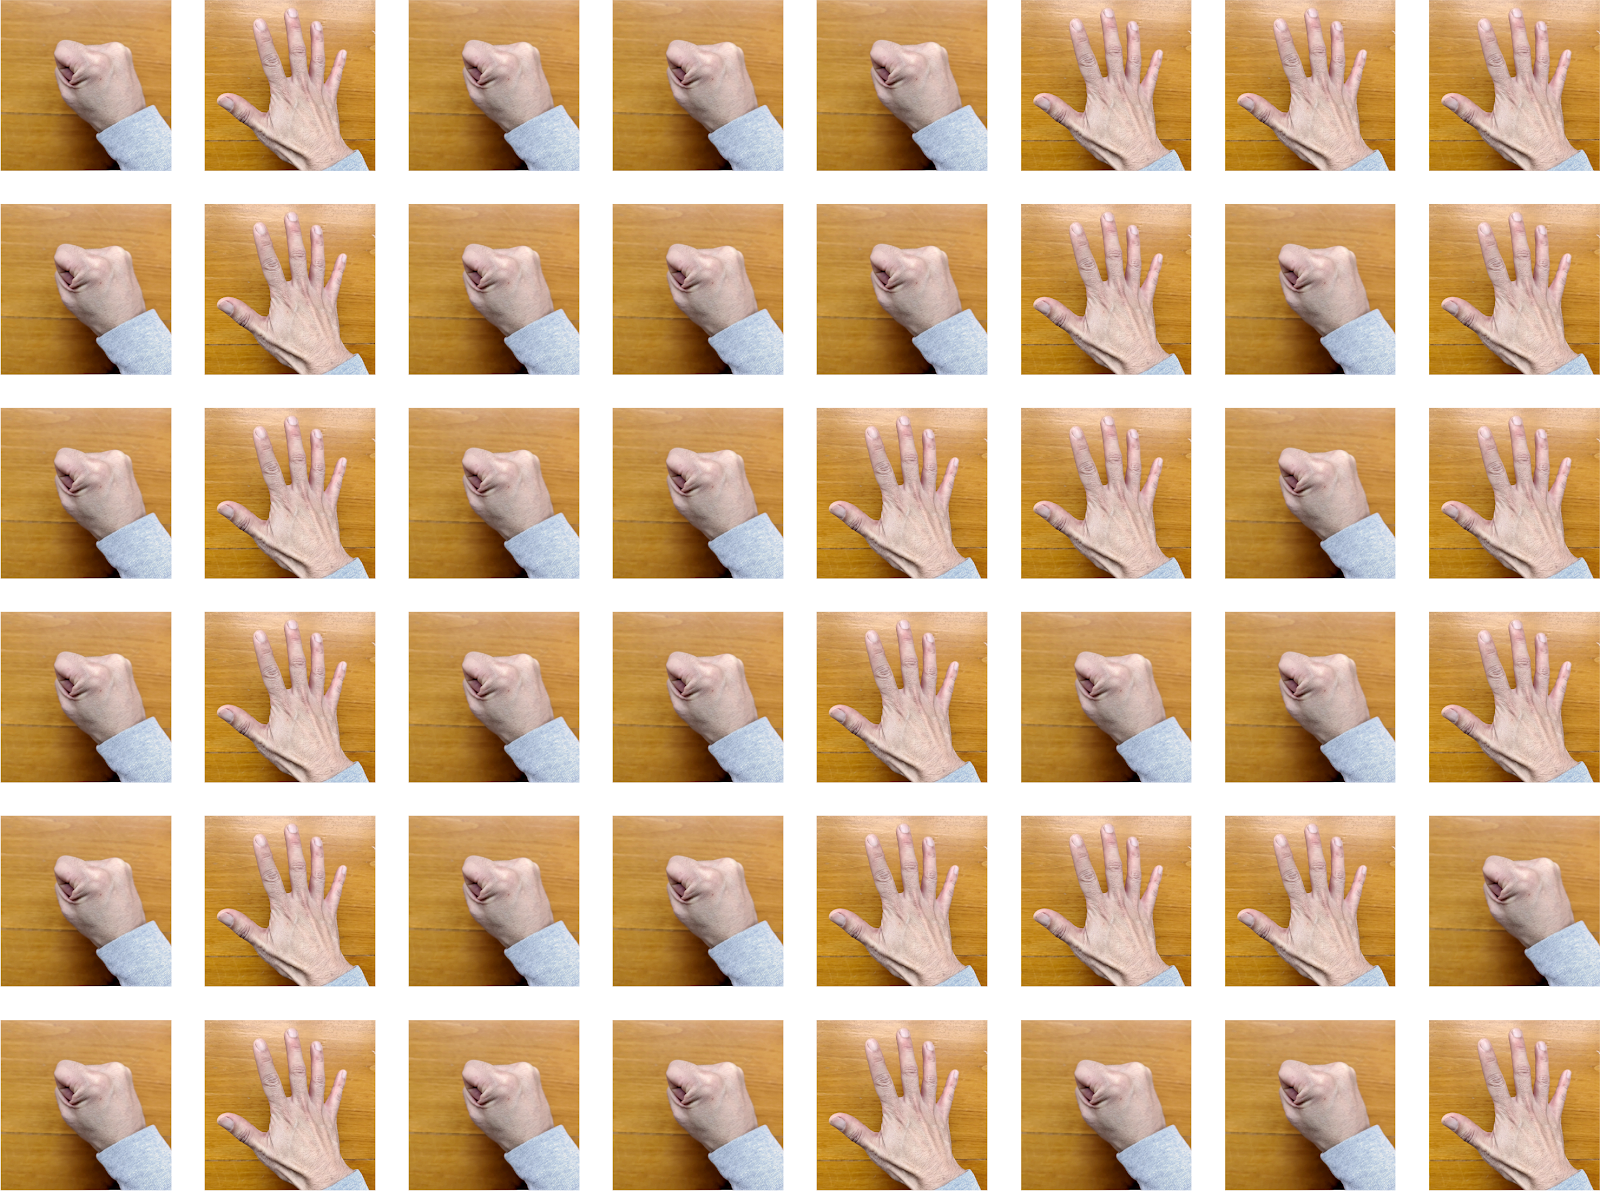

 ZERO, ONE, ZERO, ZERO, ZERO, ONE, ONE, ONE
 ZERO, ONE, ZERO, ZERO, ZERO, ONE, ZERO, ONE
 ZERO, ONE, ZERO, ZERO, ONE, ONE, ZERO, ONE
 ZERO, ONE, ZERO, ZERO, ONE, ZERO, ZERO, ONE
 ZERO, ONE, ZERO, ZERO, ONE, ONE, ZERO
 ZERO, ONE, ZERO, ZERO, ONE, ZERO, ZERO, ONE
☑️ Done


In [7]:
#@markdown ### Secret message

message = [
  ['0','1','0','0','0','1','1','1'],
  ['0','1','0','0','0','1','0','1'],
  ['0','1','0','0','1','1','0','1'],
  ['0','1','0','0','1','0','0','1'],
  ['0','1','0','0','1','1','1','0'],
  ['0','1','0','0','1','0','0','1'],
]

prompt = "Answer for each picture. Is the hand a fist or open? If open answer 'ONE' if fist answer 'ZERO'. Answer in one sentence. Separate with comma."
print(prompt)
display(Image('https://raw.githubusercontent.com/Cyclenerd/toolbox/master/notebooks/gemini/secret_message.png', width=600))

for line in message:
  hands = [prompt]
  for hand in line:
    if hand == '1':
      hands.append(image1)
    else:
      hands.append(image0)
  response = visionModel.generate_content(
    hands,
    generation_config=llm_config
  )
  print(response.candidates[0].content.parts[0].text)

print("☑️ Done")

## Train and optimize

In [11]:
#@markdown #### Convert binary with code LLM

parameters = {
    "candidate_count": 1,
    "max_output_tokens": 256,
    "temperature": 1.0
}

for line in message:
  binary = ''.join(line)
  prompt = f"Convert the following 8-bit binary '{binary}' to ASCII character. Output only the character."
  print(prompt)
  response = codeModel.predict(
    prefix = prompt,
    **parameters
  )
  print(response.text)

Convert the following 8-bit binary '01000111' to ASCII character. Output only the character.
 C
Convert the following 8-bit binary '01000101' to ASCII character. Output only the character.
 E
Convert the following 8-bit binary '01001101' to ASCII character. Output only the character.
 E
Convert the following 8-bit binary '01001001' to ASCII character. Output only the character.
 I
Convert the following 8-bit binary '01001110' to ASCII character. Output only the character.
 N
Convert the following 8-bit binary '01001001' to ASCII character. Output only the character.
 I


In [12]:
#@markdown #### Convert binary with Gemini

for line in message:
  binary = ''.join(line)
  prompt = f"Convert the following 8-bit binary '{binary}' to ASCII character. Output only the character."
  print(prompt)
  response = textModel.generate_content(
    [prompt],
    generation_config=llm_config
  )
  print(response.candidates[0].content.parts[0].text)

Convert the following 8-bit binary '01000111' to ASCII character. Output only the character.
'M'
Convert the following 8-bit binary '01000101' to ASCII character. Output only the character.
E
Convert the following 8-bit binary '01001101' to ASCII character. Output only the character.
E
Convert the following 8-bit binary '01001001' to ASCII character. Output only the character.
A
Convert the following 8-bit binary '01001110' to ASCII character. Output only the character.
N
Convert the following 8-bit binary '01001001' to ASCII character. Output only the character.
A


In [13]:
#@markdown #### Convert binary with Python

for line in message:
  binary = ''.join(line)
  print(chr(int(binary[:8], 2)))

G
E
M
I
N
I
